https://gpitbjss.atlassian.net/browse/PRMT-1955
### [Hypothesis] Proportion of TPP-EMIS error code 99s will have reduced from February to March
### Hypothesis

**We believe** that transfers resulting in error code 99’s from TPP to EMIS

**Will** have reduced in proportion from February to March 2021

**We will know this to be true when** we see that the % of all TPP-EMIS transfers resulting is this error is lower in March than in February

 

### Scope
- Generate a break down of error codes per supplier pathway for February, and a separate one for March
- Identify the total number of TPP-EMIS transfers for both February and March
- Calculate what % of the total number of TPP-EMIS transfers resulted in error code 99, for both February and March

### Acceptance Criteria
- We know whether the proportion of error code 99s has decreased
- We have a confluence page that shows the two monthly breakdowns - specifically a comparison of the proportions of the error code 99s between TPP-EMIS and EMIS-EMIS

## Import and prep data

In [1]:
import matplotlib.pyplot as plt 

In [2]:
import pandas as pd
import numpy as np
# Using data generated from branch PRMT-1742-duplicates-analysis.
# This is needed to correctly handle duplicates.
# Once the upstream pipeline has a fix for duplicate EHRs, then we can go back to using the main output.
transfer_file_location = "s3://prm-gp2gp-data-sandbox-dev/transfers-duplicates-hypothesis/"
transfer_files = [
    "2-2021-transfers.parquet",
    "3-2021-transfers.parquet"
]

transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers_raw = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))

# In the data from the PRMT-1742-duplicates-analysis branch, these columns have been added , but contain only empty values.
transfers_raw = transfers_raw.drop(["sending_supplier", "requesting_supplier"], axis=1)


# Given the findings in PRMT-1742 - many duplicate EHR errors are misclassified, the below reclassifies the relevant data

has_at_least_one_successful_integration_code = lambda errors: any((np.isnan(e) or e==15 for e in errors))
successful_transfers_bool = transfers_raw['request_completed_ack_codes'].apply(has_at_least_one_successful_integration_code)
transfers = transfers_raw.copy()
transfers.loc[successful_transfers_bool, "status"] = "INTEGRATED"

# Correctly interpret certail sender errors as failed.
# This is explained in PRMT-1974. Eventaully this will be fixed upstream in the pipeline. 
pending_sender_error_codes=[6,7,10,24,30,23,14,99]
transfers_with_pending_sender_code_bool=transfers['sender_error_code'].isin(pending_sender_error_codes)
transfers_with_pending_with_error_bool=transfers['status']=='PENDING_WITH_ERROR'
transfers_which_need_pending_to_failure_change_bool=transfers_with_pending_sender_code_bool & transfers_with_pending_with_error_bool
transfers.loc[transfers_which_need_pending_to_failure_change_bool,'status']='FAILED'

# Add integrated Late status
eight_days_in_seconds=8*24*60*60
transfers_after_sla_bool=transfers['sla_duration']>eight_days_in_seconds
transfers_with_integrated_bool=transfers['status']=='INTEGRATED'
transfers_integrated_late_bool=transfers_after_sla_bool & transfers_with_integrated_bool
transfers.loc[transfers_integrated_late_bool,'status']='INTEGRATED LATE'

# If the record integrated after 28 days, change the status back to pending.
# This is to handle each month consistentently and to always reflect a transfers status 28 days after it was made.
# TBD how this is handled upstream in the pipeline
twenty_eight_days_in_seconds=28*24*60*60
transfers_after_month_bool=transfers['sla_duration']>twenty_eight_days_in_seconds
transfers_pending_at_month_bool=transfers_after_month_bool & transfers_integrated_late_bool
transfers.loc[transfers_pending_at_month_bool,'status']='PENDING'
transfers_with_early_error_bool=(~transfers.loc[:,'sender_error_code'].isna()) |(~transfers.loc[:,'intermediate_error_codes'].apply(len)>0)
transfers.loc[transfers_with_early_error_bool & transfers_pending_at_month_bool,'status']='PENDING_WITH_ERROR'

# Supplier name mapping
supplier_renaming = {
    "EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)":"EMIS",
    "IN PRACTICE SYSTEMS LTD":"Vision",
    "MICROTEST LTD":"Microtest",
    "THE PHOENIX PARTNERSHIP":"TPP",
    None: "Unknown"
}

asid_lookup_file = "s3://prm-gp2gp-data-sandbox-dev/asid-lookup/asidLookup-Mar-2021.csv.gz"
asid_lookup = pd.read_csv(asid_lookup_file)
lookup = asid_lookup[["ASID", "MName", "NACS","OrgName"]]

transfers = transfers.merge(lookup, left_on='requesting_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'requesting_supplier', 'ASID': 'requesting_supplier_asid', 'NACS': 'requesting_ods_code','OrgName':'requesting_practice_name'}, axis=1)
transfers = transfers.merge(lookup, left_on='sending_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'sending_supplier', 'ASID': 'sending_supplier_asid', 'NACS': 'sending_ods_code','OrgName':'sending_practice_name'}, axis=1)

transfers["sending_supplier"] = transfers["sending_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())
transfers["requesting_supplier"] = transfers["requesting_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())

In [3]:
# Just the transfers relevant to the question and seperate by month
relevant_pathway_bool=(transfers['sending_supplier'].isin(['TPP','EMIS'])) & (transfers['requesting_supplier']=='EMIS')
relevant_transfers=transfers.copy().loc[relevant_pathway_bool]
relevant_transfers['Month']=relevant_transfers['date_requested'].dt.month.replace({1:'January',2:'February',3:'March'})

# Add in the set of error codes
relevant_transfers['all_errors']=relevant_transfers.apply(lambda row:np.concatenate((np.append(row["intermediate_error_codes"], row["sender_error_code"]),row['request_completed_ack_codes'])), axis=1)
relevant_transfers['all_errors']=relevant_transfers['all_errors'].apply(lambda error_list:[error for error in error_list if np.isfinite(error)])
relevant_transfers['unique_errors']=relevant_transfers['all_errors'].apply(set).apply(list)

# Add in which transfers contain error code 99
relevant_transfers['Contains error code 99']=relevant_transfers['all_errors'].apply(lambda error_list: 99 in error_list).astype(int)

In [4]:
relevant_transfers['Status at 28 days']=relevant_transfers['status'].apply(lambda x: x.replace('_',' ').title())
relevant_transfers.loc[relevant_transfers['Status at 28 days']=="Pending","Status at 28 days"]="Pending Without Error"

In [5]:
relevant_transfers['Supplier Pathway']=relevant_transfers['sending_supplier'] + ' to ' + relevant_transfers['requesting_supplier']

### A. What proportion of transfers still have Error Code 99?

In [6]:
change_in_99=relevant_transfers.groupby(['Supplier Pathway','Month']).agg({'Contains error code 99':['count','sum','mean']})
change_in_99=change_in_99['Contains error code 99'].rename({'count':'Total Transfers','sum':'Transfers with Error 99','mean':'% Transfers with Error 99'},axis=1)
change_in_99['% Transfers with Error 99']=change_in_99['% Transfers with Error 99'].multiply(100).round(2)
change_in_99

Total Transfers  Transfers with Error 99  \
Supplier Pathway Month                                                
EMIS to EMIS     February           142597                      215   
                 March              186714                      263   
TPP to EMIS      February            39360                     1580   
                 March               51724                      875   

                           % Transfers with Error 99  
Supplier Pathway Month                                
EMIS to EMIS     February                       0.15  
                 March                          0.14  
TPP to EMIS      February                       4.01  
                 March                          1.69

### B. What is the change in status?

In [7]:
column_order=['Integrated','Integrated Late','Pending Without Error','Pending With Error','Failed']
status_table=relevant_transfers.pivot_table(index=['Supplier Pathway','Month'],columns='Status at 28 days',values='conversation_id',aggfunc='count')
status_table=status_table[column_order]
status_table_percentage=status_table.div(status_table.sum(axis=1),axis=0).multiply(100).round(2)
status_table_percentage.columns=status_table_percentage.columns + ' %'
pd.concat([status_table,status_table_percentage],axis=1)

Status at 28 days          Integrated  Integrated Late  Pending Without Error  \
Supplier Pathway Month                                                          
EMIS to EMIS     February      131215             6671                   2755   
                 March         168289            10803                   4239   
TPP to EMIS      February       33513             1815                    864   
                 March          44808             3025                    958   

Status at 28 days          Pending With Error  Failed  Integrated %  \
Supplier Pathway Month                                                
EMIS to EMIS     February                 548    1408         92.02   
                 March                   1551    1832         90.13   
TPP to EMIS      February                  47    3121         85.14   
                 March                     85    2848         86.63   

Status at 28 days          Integrated Late %  Pending Without Error %  \
Supplier Pathway Month                                                  
EMIS to EMIS     February               4.68                     1.93   
                 March                  5.79                     2.27   
TPP to EMIS      February               4.61                     2.20   
                 March                  5.85                     1.85   

Status at 28 days          Pending With Error %  Failed %  
Supplier Pathway Month                                     
EMIS to EMIS     February                  0.38      0.99  
                 March                     0.83      0.98  
TPP to EMIS      February                  0.12      7.93  
                 March                     0.16      5.51

### C. Can we attribute status changes to the reduction of Error code 99?

In [9]:
# Create a new field to show the status and if the transfer contained error 99
contains_99={0:'(No 99)',1:'(Contains 99)'}
relevant_transfers['status and presence of 99']=relevant_transfers.apply(lambda row: row['Status at 28 days']+ ' '+contains_99[row['Contains error code 99']],axis=1)

In [10]:
status_and_99_table_count=relevant_transfers.pivot_table(index=['Supplier Pathway','Month'],columns='status and presence of 99',values='status',aggfunc='count').fillna(0).astype(int)
new_column_order=['Integrated (No 99)','Integrated (Contains 99)','Integrated Late (No 99)','Integrated Late (Contains 99)','Pending Without Error (No 99)','Pending Without Error (Contains 99)','Pending With Error (No 99)','Pending With Error (Contains 99)','Failed (No 99)','Failed (Contains 99)']
new_column_order=[column_name for column_name in new_column_order if column_name in status_and_99_table_count.columns]
status_and_99_table_count=status_and_99_table_count.loc[:, new_column_order]

status_and_99_table_count

status and presence of 99  Integrated (No 99)  Integrated (Contains 99)  \
Supplier Pathway Month                                                    
EMIS to EMIS     February              131209                         6   
                 March                 168281                         8   
TPP to EMIS      February               33504                         9   
                 March                  44790                        18   

status and presence of 99  Integrated Late (No 99)  \
Supplier Pathway Month                               
EMIS to EMIS     February                     6671   
                 March                       10803   
TPP to EMIS      February                     1815   
                 March                        3024   

status and presence of 99  Integrated Late (Contains 99)  \
Supplier Pathway Month                                     
EMIS to EMIS     February                              0   
                 March                                 0   
TPP to EMIS      February                              0   
                 March                                 1   

status and presence of 99  Pending Without Error (No 99)  \
Supplier Pathway Month                                     
EMIS to EMIS     February                           2755   
                 March                              4239   
TPP to EMIS      February                            864   
                 March                               958   

status and presence of 99  Pending With Error (No 99)  \
Supplier Pathway Month                                  
EMIS to EMIS     February                         548   
                 March                           1551   
TPP to EMIS      February                          45   
                 March                             85   

status and presence of 99  Pending With Error (Contains 99)  Failed (No 99)  \
Supplier Pathway Month                                                        
EMIS to EMIS     February                                 0            1199   
                 March                                    0            1577   
TPP to EMIS      February                                 2            1552   
                 March                                    0            1992   

status and presence of 99  Failed (Contains 99)  
Supplier Pathway Month                           
EMIS to EMIS     February                   209  
                 March                      255  
TPP to EMIS      February                  1569  
                 March                      856

In [11]:
status_and_99_table_percentage=status_and_99_table_count.div(status_and_99_table_count.sum(axis=1),axis=0).multiply(100)
status_and_99_table_percentage.round(2)

status and presence of 99  Integrated (No 99)  Integrated (Contains 99)  \
Supplier Pathway Month                                                    
EMIS to EMIS     February               92.01                      0.00   
                 March                  90.13                      0.00   
TPP to EMIS      February               85.12                      0.02   
                 March                  86.59                      0.03   

status and presence of 99  Integrated Late (No 99)  \
Supplier Pathway Month                               
EMIS to EMIS     February                     4.68   
                 March                        5.79   
TPP to EMIS      February                     4.61   
                 March                        5.85   

status and presence of 99  Integrated Late (Contains 99)  \
Supplier Pathway Month                                     
EMIS to EMIS     February                            0.0   
                 March                               0.0   
TPP to EMIS      February                            0.0   
                 March                               0.0   

status and presence of 99  Pending Without Error (No 99)  \
Supplier Pathway Month                                     
EMIS to EMIS     February                           1.93   
                 March                              2.27   
TPP to EMIS      February                           2.20   
                 March                              1.85   

status and presence of 99  Pending With Error (No 99)  \
Supplier Pathway Month                                  
EMIS to EMIS     February                        0.38   
                 March                           0.83   
TPP to EMIS      February                        0.11   
                 March                           0.16   

status and presence of 99  Pending With Error (Contains 99)  Failed (No 99)  \
Supplier Pathway Month                                                        
EMIS to EMIS     February                              0.00            0.84   
                 March                                 0.00            0.84   
TPP to EMIS      February                              0.01            3.94   
                 March                                 0.00            3.85   

status and presence of 99  Failed (Contains 99)  
Supplier Pathway Month                           
EMIS to EMIS     February                  0.15  
                 March                     0.14  
TPP to EMIS      February                  3.99  
                 March                     1.65

In [12]:
lm_color_table=dict()
lm_color_table['Integrated (No 99)']='#9EE09E'
lm_color_table['Integrated (Contains 99)']='#FFF'
lm_color_table['Integrated Late (No 99)']='#9EC1CF'
lm_color_table['Integrated Late (Contains 99)']='#FFF'
lm_color_table['Pending Without Error (No 99)']='#CC99C9'
lm_color_table['Pending With Error (No 99)']='#FDFD97'

lm_color_table['Pending With Error (Contains 99)']='#FFF'
lm_color_table['Failed (Contains 99)']='#FF6663'
lm_color_table['Failed (No 99)']='#FEB144'


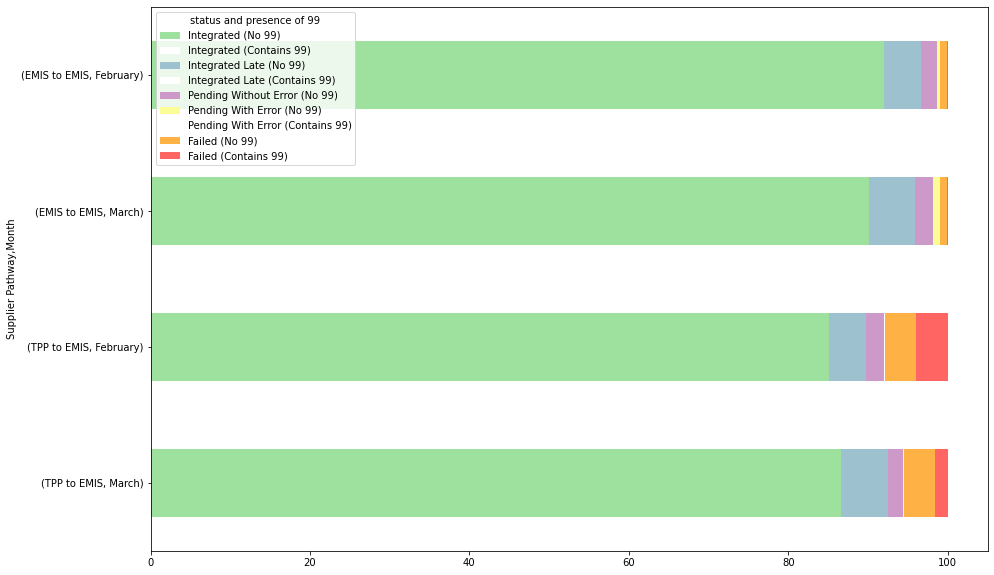

In [13]:
status_and_99_table_percentage.plot.barh(stacked=True,figsize=(15,10),color=lm_color_table)
plt.gca().invert_yaxis()